In [2]:
#!/usr/bin/env python3
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import astropy.units as u
from sunpy.time import TimeRange
import time
import sys

import datetime as dt
import matplotlib.dates as mdates
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import gridspec,transforms

%matplotlib inline

In [3]:
sys.path.insert(1, '../../20201013_jupiter/')
from sk import LofarRaw


#rcParams['agg.path.chunksize'] = 10000

In [4]:
mpl.use('nbagg')

In [5]:
filename = '../udpoutput/uranus-stokesVectors_0_2020-12-15T20:04:00_19629670898060' #0 is I and 1 is V I assume
frange = [15,30]
sbs = np.arange(76,198)
obs_mode = 3
time_len_mins = 176.
trange = TimeRange(filename.split('_')[-2], time_len_mins*u.min)
xlabel = "Time from {} {}".format(filename.split('_')[-2].split('T')[0], filename.split('_')[-2].split('T')[1])
ylabel = "Frequency (MHz)"
title = filename.split('/')[2]

In [6]:
off_fname = '../udpoutput/offsource-stokesVectors_0_2020-12-15T20:04:00_19629670898060'
#trange is the same for both beams
#time_len_mins = 176.
#offtrange = TimeRange(off_fname.split('_')[-2], time_len_mins*u.min)
#offxlabel = "Time from {} {}".format(off_fname.split('_')[-2].split('T')[0], off_fname.split('_')[-2].split('T')[1])
#offylabel = "Frequency (MHz)"
#offtitle = off_fname.split('/')[2]

In [14]:
# read in the data (stokes I or V from udpPM)
raw = LofarRaw(fname=filename, sbs=sbs, obs_mode=obs_mode, frange=frange)
raw.data = raw.data[:,:78] ###the rest of the subbands are empty because of the way ilofar/realta records data into the data lanes
offraw = LofarRaw(fname=off_fname, sbs=sbs, obs_mode=obs_mode, frange=frange)
offraw.data = offraw.data[:,:78]

Time to read data: 0.000917s

Time to read data: 0.000133s



In [15]:
flimits = np.array([0,78])
freqlimits = raw.sb_to_f(flimits+sbs[0], obs_mode)
xlims = list(map(dt.datetime.fromisoformat, [trange.start.value, trange.end.value]))
xlims = mdates.date2num(xlims)

In [16]:
datasplit = 10
normseconds = 42
norm_splits = int(((trange.minutes.value/datasplit)*60)/normseconds)

tchunks = trange.split(datasplit)
datas = np.array_split(raw.data, datasplit, axis=0)
offdatas = np.array_split(offraw.data, datasplit, axis=0)

In [41]:
def plot_data(data, trange, flims, xlabel, ylabel, plotname):
    f = plt.figure(figsize=(12,6))
    f.set_facecolor('white')

    spec = gridspec.GridSpec(ncols=2, nrows=2, width_ratios=[6,1], height_ratios=[1,4])
    ax0 = f.add_subplot(spec[0])
    ax2 = f.add_subplot(spec[2])
    ax3 = f.add_subplot(spec[3])

    ys = data.T.sum(axis=1)
    """
    #rfi removal snippet

    sigma = 2.*np.std(ys) #2sigma
    ymean = np.mean(ys)
    print(ymean+sigma)

    for i,j in enumerate(ys[::-1]):
            if j > (ymean+sigma):
                    print("RFI trigger {}".format(i))
                    ys[i] = np.NaN 
                    data[:, i] = np.NaN
    """
    xs = np.nansum(data.T, axis=0)

    ax0.plot(xs, lw=0.5)
    ax0.set(xticklabels=[], xlim=[0,None])
    ax0.tick_params(bottom=False)

    rot = transforms.Affine2D().rotate_deg(270)
    ax3.plot(ys[::-1], lw=0.5, transform=rot+plt.gca().transData)
    ax3.set(yticklabels=[])
    ax3.tick_params(left=False)

    xlims = list(map(dt.datetime.fromisoformat, [trange.start.value, trange.end.value]))
    xlims = mdates.date2num(xlims)

    im = ax2.imshow(data.T, aspect='auto', origin='lower',
            vmin=np.nanpercentile(data.T, 5), 
            vmax=np.nanpercentile(data.T, 90),
            extent=[xlims[0], xlims[1], 
                    flims[0].value, flims[1].value])

    ax2.xaxis_date()
    date_format = mdates.DateFormatter('%H:%M:%S')
    ax2.xaxis.set_major_formatter(date_format)

    ax2.set_title("Uranus observation - Stokes I")
    ax2.set_ylabel(ylabel, fontsize=14)
    ax2.set_xlabel(xlabel, fontsize=14)

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="3%", pad=0.05)
    plt.colorbar(im, cax=cax)

    plt.tight_layout()
    plt.savefig(plotname, dpi=900)

In [42]:
for i,j in enumerate(datas):
    print("Analysing chunk #{} of data".format(i+1))

    bg = np.true_divide(j, offdatas[i], out=np.zeros_like(j), where=offdatas[i]!=0) #bg removal... 

    #dec = 256
    #dec = 3662 # dec = 3662 gives a resolution of 150 ms
    #summed = np.cumsum(bg, axis=0)
    #dec_data = summed[dec::dec, :] - summed[:-dec:dec, :]

    #dec = 1831 #resolution of 150ms for this method
    dec = 12207 #resolution of 1s
    pad = np.ceil(float(bg.shape[0])/dec)*dec - bg.shape[0]
    pad_arr = np.zeros((int(pad), bg.shape[1]))*np.NaN
    bg_padded = np.append(bg, pad_arr).reshape(-1, bg.shape[1])
    dec_data = np.nanmean(bg_padded.T.reshape(bg.shape[1], -1, dec), axis=2).T

    #norm freq response
    n_data = dec_data / np.mean(dec_data, axis=0)
    
    #print('\tData downsampled x{}'.format(int(dec/2)))
    print('\tData downsampled x{}'.format(int(dec)))
    print('\t Data shape: {}'.format(dec_data.shape))

    print("\tPlotting...\n")
    plot_data(n_data, tchunks[i], freqlimits, xlabel, ylabel, 'bgr_fn_sI_1sres/bg_removed_freqnormed_rfiremove_{}.png'.format(i+1))

Analysing chunk #1 of data
	Data downsampled x12207
	 Data shape: (1057, 78)
	Plotting...



<IPython.core.display.Javascript object>

Analysing chunk #2 of data
	Data downsampled x12207
	 Data shape: (1057, 78)
	Plotting...



<IPython.core.display.Javascript object>

Analysing chunk #3 of data
	Data downsampled x12207
	 Data shape: (1057, 78)
	Plotting...



<IPython.core.display.Javascript object>

Analysing chunk #4 of data
	Data downsampled x12207
	 Data shape: (1057, 78)
	Plotting...



<IPython.core.display.Javascript object>

Analysing chunk #5 of data
	Data downsampled x12207
	 Data shape: (1057, 78)
	Plotting...



<IPython.core.display.Javascript object>

Analysing chunk #6 of data
	Data downsampled x12207
	 Data shape: (1057, 78)
	Plotting...



<IPython.core.display.Javascript object>

Analysing chunk #7 of data
	Data downsampled x12207
	 Data shape: (1057, 78)
	Plotting...



<IPython.core.display.Javascript object>

Analysing chunk #8 of data
	Data downsampled x12207
	 Data shape: (1057, 78)
	Plotting...



<IPython.core.display.Javascript object>

Analysing chunk #9 of data
	Data downsampled x12207
	 Data shape: (1057, 78)
	Plotting...



<IPython.core.display.Javascript object>

Analysing chunk #10 of data
	Data downsampled x12207
	 Data shape: (1057, 78)
	Plotting...



<IPython.core.display.Javascript object>

In [52]:
### looking at the 1s resolution data, there is an event in the 2nd chunk warranting a further looksee
subcut = 
subdata = np.true_divide(datas[1][subcut[0]:subcut[1]], offdatas[1][subcut[0]:subcut[1]], out=np.zeros_like(datas[1][subcut[0]:subcut[1]]), where=offdatas[1][subcut[0]:subcut[1]]!=0)
subt = tchunks[1].split(4)[1]

In [53]:
subdata.shape

(3222657, 78)

In [48]:
datas[1].shape

(12890627, 78)

In [60]:
subdata = datas[1][:,62]
subdata = np.array_split(subdata, 10, axis=0)

In [63]:
%matplotlib inline

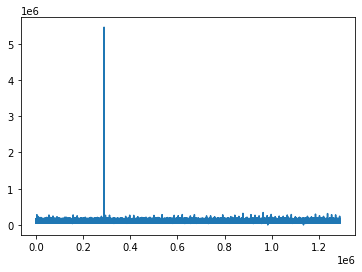

In [67]:
plt.plot(subdata[2])

In [83]:
subdata2 = subdata[2][289100:289200]

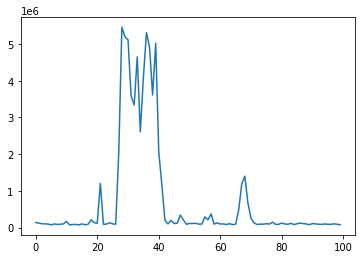

In [84]:
plt.plot(subdata2)

In [ ]:
#duration = datapoints X resolution 
#duration = ~20*81.92e-6 = 0.001638 s
#that is way too short. 

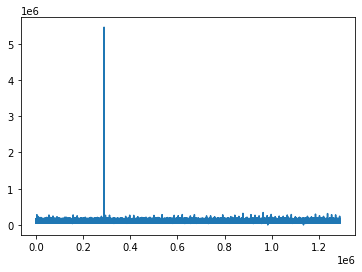

In [86]:
plt.plot(subdata[2])

In [153]:
def plot_data_now(data, rfis, trange, flims, xlabel, ylabel):
    f = plt.figure(figsize=(12,6))
    f.set_facecolor('white')

    spec = gridspec.GridSpec(ncols=2, nrows=2, width_ratios=[6,1], height_ratios=[1,4])
    ax0 = f.add_subplot(spec[0])
    ax2 = f.add_subplot(spec[2])
    ax3 = f.add_subplot(spec[3])

    #data[:,rfis] = np.NaN
    ys = data.T.sum(axis=1)
    sigma_y = 2.*np.std(ys) #2sigma
    ymean = np.mean(ys)
    print(ymean+sigma_y)

    for i,j in enumerate(ys[::-1]):
            if j > (ymean+sigma_y):
                    print("RFI trigger channel : {}".format(i))
                    ys[i] = np.NaN 
                    data[:, i] = np.NaN

    #ys = data.T.sum(axis=1)
    xs = np.nansum(data.T, axis=0)
    sigma_x = 2.*np.nanstd(xs) #2sigma
    xmean = np.nanmean(xs)
    print(xmean + sigma_x)
    for i,j in enumerate(xs):
        if j> (xmean+sigma_x):
            print("RFI trigger time sample : {}".format(i))
            xs[i] = np.NaN
            data[i, :] = np.NaN

    ax0.plot(xs, lw=0.5)
    ax0.set(xticklabels=[], xlim=[0,None])
    ax0.tick_params(bottom=False)

    rot = transforms.Affine2D().rotate_deg(270)
    ax3.plot(ys[::-1], lw=0.5, transform=rot+plt.gca().transData)
    ax3.set(yticklabels=[])
    ax3.tick_params(left=False)

    xlims = list(map(dt.datetime.fromisoformat, [trange.start.value, trange.end.value]))
    xlims = mdates.date2num(xlims)

    im = ax2.imshow(data.T, aspect='auto', origin='lower',
            vmin=np.nanpercentile(data.T, 5), 
            vmax=np.nanpercentile(data.T, 90),
            extent=[xlims[0], xlims[1], 
                    flims[0].value, flims[1].value])

    ax2.xaxis_date()
    date_format = mdates.DateFormatter('%H:%M:%S')
    ax2.xaxis.set_major_formatter(date_format)

    ax2.set_title("Uranus observation - Stokes I")
    ax2.set_ylabel(ylabel, fontsize=14)
    ax2.set_xlabel(xlabel, fontsize=14)

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="3%", pad=0.05)
    plt.colorbar(im, cax=cax)

    plt.tight_layout()
    plt.show()

In [154]:
def plotter(dataindex, dec, rfis):
    """
    dataindex is the index of the chunk of data
    """
    #dec = 12207 resolution of 1s
    bg = datas[dataindex]
    pad = np.ceil(float(bg.shape[0])/dec)*dec - bg.shape[0]
    pad_arr = np.zeros((int(pad), bg.shape[1]))*np.NaN
    bg_padded = np.append(bg, pad_arr).reshape(-1, bg.shape[1])
    dec_data = np.nanmean(bg_padded.T.reshape(bg.shape[1], -1, dec), axis=2).T

    n_data = dec_data / np.mean(dec_data, axis=0)

    plot_data_now(n_data, rfis, tchunks[dataindex], freqlimits, xlabel, ylabel)

    return n_data

In [152]:
subdata = plotter(8, 366, [20, 72])

NameError: name 'ys' is not defined

In [141]:
subdata1 = subdata[72780:72850,63]

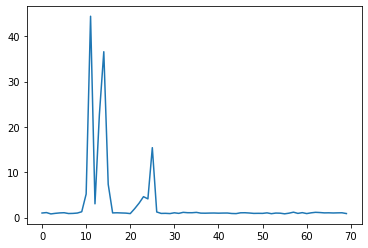

In [142]:
plt.plot(subdata1)

In [120]:
subdata.shape

(3222657, 78)